In [1]:
from bs4 import BeautifulSoup as soup
import requests
import pandas as pd
import time

start_time = time.time()
end_time = 0

domain = "https://www.bolha.com"
params = ['Znamka avtomobila:', 'Model avtomobila:', 'Tip avtomobila:', 'Leto izdelave:', 'Prevoženi kilometri:']
results_df = pd.DataFrame(data=None, index=None, columns=params.append('Cena:'))
results_df.index +=1

page_number = '1'
ad_number = 1

# Individual page processing
while int(page_number) <= 50:
    request_page = requests.get(domain + '/rabljeni-avtomobili?page=' + page_number)
    page_soup = soup(request_page.content,'html.parser')
#     print(page_number)

    page_cars_html = page_soup.find_all('h3',{'class':'entity-title'})
#     print(len(page_cars_html))
    
    # Individual car processing
    for car_html in page_cars_html:
        single_car_url = car_html.a.get('href')
        
        if 'avto-oglasi' in single_car_url:
#             print(single_car_url)
            single_car_req = requests.get(domain + single_car_url)
            car_info = soup(single_car_req.content,'html.parser')

            car_price_html = car_info.find('li',{'class':'price-item--base'}).find('strong',{'class':'price'})
            car_price = car_price_html.get_text().replace('\n','').replace(' ','').replace('\xa0',' ')
            #car_table = car_info.find('tbody').find_all('tr')
            #car_type = car_table[2].find('td').text + ' ' + car_table[3].find('td').text + ', '+ car_table[4].find('td').text
            #car_year = car_table[5].find('td').text
            #car_mileage = car_table[10].find('td').text

            # Find table of properties I'm interested in.
            my_list = car_info.find('tbody')
            result_dict = {'Cena:':car_price, 'Stran:':page_number, 'Oglas:':str(ad_number)}
#             print(result_dict.values())

            # Loops across all parameters, finds the index, takes result, stores in a dictionary
            for param in params:
                for i,each_param in enumerate(my_list.find_all('th')):
                    if param in each_param:
                        value = my_list.find_all('tr')[i].find('td').text
                        if value is not None:
                            result_dict.update({param : value})
                            
            #Once an individual ad is processed, increment of ad_number.
            ad_number +=1

            # Dictionary of results is stored in results dataframe only if it found properties other than price
            # Only include prices greater than 99 €
            # Exclude ads with no defined price
            if result_dict['Znamka avtomobila:'] is not None and \
                result_dict['Model avtomobila:'] is not None and \
                result_dict['Tip avtomobila:'] is not None and \
                result_dict['Leto izdelave:'] is not None and \
                result_dict['Prevoženi kilometri:'] is not None and \
                len(result_dict['Cena:']) > 4 and \
                "dogovor" not in result_dict['Cena:'] :
                results_df = results_df.append(result_dict, ignore_index=True)
#                 print("Stran: " + str(page_number))

#             print("Next car!")
        else:
            pass
#             print("Not a car!")

            
    # Find a link to next page; if not there, break the while loop
    try:
        page_number = page_soup.find('li',{'class':'Pagination-item--next'}).find('button').get('data-page')
#         print("New: "+page_number)
    except AttributeError:
        print("Done!")
#         end_time = time.time()
        break
    else:
        continue
    break
                
                
print("Runtime: %s seconds" % (round(time.time() - start_time, 2)))

Runtime: 1048.01 seconds


#### Edit data

In [ ]:
# filter_1 = ~results_df['Leto izdelave:'].isnull()
# filter_2 = 
#msno.matrix(results_df[~results_df['Leto izdelave:'].isnull()])
# plt.plot(results_df['Leto izdelave:'],'.')
# plt.plot('Cena:', 'Leto izdelave:')

# results_df.info()
# results_df = results_copy.copy(deep=True)

#Backup copy of results
results_copy = results_df.copy(deep=True)

# Trim values
results_df['Cena:'][~results_df['Cena:'].str.contains('€')] #Discard € sign
temp_result = results_df['Cena:'].str.slice(stop = -2) #Remove extra characters
temp_result = temp_result.str.replace('.','') #Remove 1k markers
temp_result = temp_result.str.replace(',','.') #Change decimal point
results_df['Cena:'] = temp_result
temp_result = results_df['Prevoženi kilometri:'].str.slice(stop = -3) #Remove extra characters
results_df['Prevoženi kilometri:'] = temp_result

# Edit order of columns
col_key = results_df.columns.to_list()
col_val = [key[:-1] for key in col_key]
col_dict = {col_key[i]:col_val[i] for i in range(len(col_key))}
results_df = results_df.rename(columns=col_dict)

# Rename columns
temp = ['Oglas','Stran','Znamka avtomobila','Tip avtomobila','Model avtomobila','Leto izdelave','Prevoženi kilometri','Cena']
results_df = results_df[temp]
results_df.columns = [temp]

# Reformat columns: all numbers from strings to integer/float
type_dict = {'Cena':'float64','Prevoženi kilometri':'int64','Leto izdelave':'int64'}
results_df = results_df.astype(dtype=type_dict)
results_df

### Storage of results

In [ ]:
# Define SQLlite database, input results of webscraping. How to update with time? Check every entry? Might take time.
from sqlalchemy import create_engine
# import sqlite3

engine = create_engine('sqlite:///car_storage.db', echo=False)
conn = engine.connect()

results_df.to_sql('car_ads', conn, if_exists='fail')
conn.close()

### Retrieve results from db

In [3]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine('sqlite:///car_storage.db', echo=False)
conn = engine.connect()

sql = '''select * from car_ads where 1=1;'''

data = pd.read_sql(sql, conn, index_col='index')
data.index.name=''

In [ ]:
data

## Analiza

(0.0, 1000000.0)

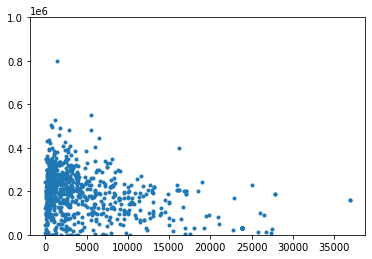

In [7]:
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.plot(data['Cena'],data['Prevoženi kilometri'],'.')
plt.ylim([0,1e6])

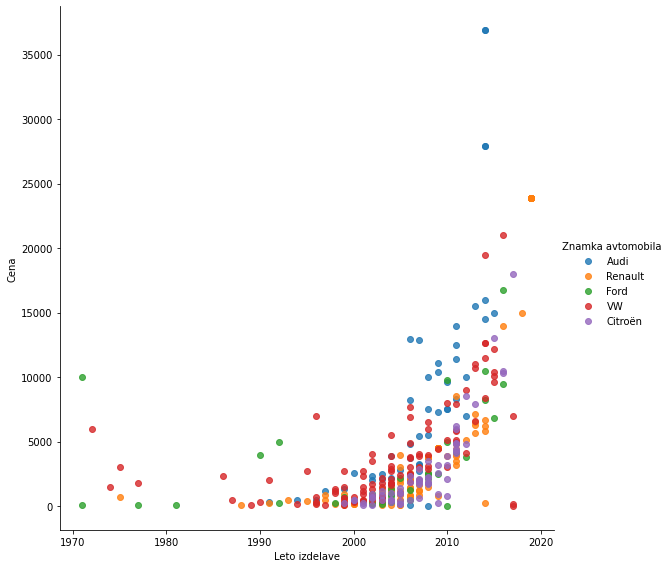

In [35]:
populars = list(data.groupby('Znamka avtomobila')['Oglas'].count().sort_values(ascending=False)[0:5].index)
my_data = data[data['Znamka avtomobila'].isin(populars)]

X = my_data['Leto izdelave']
Y = my_data['Cena']
Z = my_data['Prevoženi kilometri']

# plt.plot(X,Y,'.')

# x_fit = np.arange(1970,2021,1)
# y_fit = np.exp(0.184 *x_fit -361.315)
# y_fit = np.exp(0.2083 *x_fit -410.77)



# plt.plot(x_fit,y_fit)
sns.lmplot(data=my_data, x='Leto izdelave', y='Cena', hue='Znamka avtomobila', height=8, fit_reg=False)
# sns.regplot(X, Y, fit_reg=False, order=1, logx=True)
# sns.lmplot(data=my_data[my_data['Znamka avtomobila']=='Renault'], x='Leto izdelave', y='Cena', height=8)


# plt.plot([1996,2020],[5,10], linewidth=5, color='orange')
# plt.plot([1995,],[5,], linewidth=4, color='green')
# plt.ylim(4, 10)
# plt.xlim(0, 1e6)
# plt.rcParams['figure.figsize'] = [5,8]# v inčah!
# plt.show()
# plt.plot(X,Y,'.')
# plt.plot(Y,'.-')

In [50]:
from tqdm import tqdm

A = np.arange(0.15,0.25,0.001)
B = np.arange(-450,-400,1)
# B = -410.77

def grad_desc(a,b,alpha,epoch):
    for i in range(epoch):
        temp = np.log(Y) - (a*X + b)
        temp_a = sum(temp) /temp.shape[0]
        temp_b = sum(temp *X) /temp.shape[0]
        
        a = a -alpha *temp_a
        b = b -alpha *temp_b
    return(round(a,3), round(b,3))

res_A = list()
res_B = list()

for b in tqdm(B):
    for a in A:
        res_a, res_b = grad_desc(a,b,0.001,20)
        res_A.append(res_a)
        res_B.append(res_b)
        
#         min(res_A)
#         min(res_B)

100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


In [ ]:
# print(grad_desc(0.2, -214, 0.01, 1000))
# res_A
res_A

In [ ]:
x_fit = np.arange(1970,2021,1)
y_fit = np.exp(0.184 *x_fit -361.315)
print(y_fit)

In [ ]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(b * x) + c

popt, pcov = curve_fit(func, X, Y)